In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial.distance
import scipy

In [2]:
GT = np.genfromtxt('ds0_Groundtruth.dat', skip_header = 3, skip_footer = 0, names = True, dtype = None, delimiter = ' ' , usecols = [0, 3, 5, 7])
Odom = np.genfromtxt('ds0_Odometry.dat', skip_header = 3, skip_footer = 0, names = True, dtype = None, delimiter = ' ' , usecols = [0,4,5])

In [3]:
start_time = GT[0][0]
for i in range(len(GT)):
    GT[i][0]-= start_time
for i in range(len(Odom)):
    Odom[i][0]-=start_time

In [4]:
j = 1
k = 1
align = []

for i in range (len(GT)):
    match = 0
    while (match == 0 and j < len(GT) and k < len(Odom)-1):
        if (GT[j][0] - Odom[k][0] > 0 and GT[j][0] - Odom[k+1][0]<= 0):
            align.append((GT[j], Odom[k]))
            j+=1
            match = 1
        else:
            k+=1

In [5]:
train_in = []
train_out = []

test_in = []
test_out = []

val_in = []
val_out = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0

for i in range(len(align) - 2):
    
    dt_in = align[i+1][0][0] - align[i][0][0]
    
    x_in = align[i+1][0][1] - align[i][0][1]
    y_in = align[i+1][0][2] - align[i][0][2]
    theta_in = align[i+1][0][3] - align[i][0][3]
    
    v_in = align[i+1][1][1] - align[i][1][1]
    w_in = align[i+1][1][2] - align[i][1][2]

    dt_out = align[i+2][0][0] - align[i+1][0][0] # (t+1) - (t)
    
    x_out = align[i+2][0][1] - align[i+1][0][1]
    y_out = align[i+2][0][2] - align[i+1][0][2]
    theta_out = align[i+2][0][3] - align[i+1][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        test_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        val_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
        ind_count+=1
    else:
        train_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        train_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
    

In [6]:
train_in2 = []
train_out2 = []

test_in2 = []
test_out2 = []

val_in2 = []
val_out2 = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0

for i in range(len(align) - 2):
    
    dt_in = align[i+1][0][0] - align[i][0][0]
    
    x_in = align[i+1][0][1] - align[i][0][1]
    y_in = align[i+1][0][2] - align[i][0][2]
    theta_in = align[i+1][0][3] - align[i][0][3]
    
    v = np.sqrt(((x_in/dt_in)**2)+((y_in/dt_in)**2))
    w = theta_in/dt_in
    
    v_in = align[i+1][1][1] - align[i][1][1]
    w_in = align[i+1][1][2] - align[i][1][2]
    
    del_v = np.abs(v - v_in)
    del_w = np.abs(w - w_in)

    dt_out = align[i+2][0][0] - align[i+1][0][0] # (t+1) - (t)
    
    x_out = align[i+2][0][1] - align[i+1][0][1]
    y_out = align[i+2][0][2] - align[i+1][0][2]
    theta_out = align[i+2][0][3] - align[i+1][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in2.append([del_v, del_w, dt_out])
        test_out2.append([x_out, y_out, theta_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in2.append([del_v, del_w, dt_out])
        val_out2.append([x_out, y_out, theta_out])
        ind_count+=1
    else:
        train_in2.append([del_v, del_w, dt_out])
        train_out2.append([x_out, y_out, theta_out])
    

In [8]:
def RBF_1d(X1, X2, l, var):
    '''
        l = lengthscale
        var = variance (sigma^2)
        
        scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
        Compute distance between each pair of the two collections of inputs.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        
        Kxx = | k(x1,x1)   k(x1,x2)   ....   k(x1,xn) |
              |                                       |
              | k(xn,x1)   k(xn,x2)   ....   k(xn,xn) |
    '''
    K = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            d = np.abs(X1[i] - X2[j])
            K[i][j] = var*np.exp(-(d**2)/(2*(l**2)))
            #K[j][i] = var*np.exp(-(d**2)/(2*(l**2)))
    return K

In [9]:
def GP_1d(x_in, y_out, x_test, l, var):
    '''
        x_in = 1D array of training input
        y_out = 1D array of training output
        x_test = single point of test input
    '''
    # compute kernel, covar of training input
    Kxx = RBF_1d(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + 1e-5*np.eye(x_in.shape[0])) # add noise
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html
    
    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
    
    # compute covar
    Kxxt = RBF_1d(x_in, x_test, l, var)

    # compute covar of test data
    Kxtxt = RBF_1d(x_test, x_test, l, var)
    
    # compute posterior mean
    mu_post = np.matmul(Kxxt.T, alpha)    
    
    #compute poserior covar
    v = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, Kxxt, lower=True))
    sigma_post = Kxtxt - np.matmul(Kxxt.T, v)
    
    #sigma = Kxtxt - np.dot(Kxxt, np.linalg.inv(Kxx).dot(Kxxt))
    # https://blog.dominodatalab.com/fitting-gaussian-process-models-python
    
    #mu_post = np.dot((scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T), y_out)
    #mu_post = (scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T) * y_out
    #sigma_post = Kxtxt - np.dot((scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T), Kxxt) 
    # https://peterroelants.github.io/posts/gaussian-process-tutorial/
    
    return mu_post, sigma_post

In [43]:
def RBF_nd(X1, X2, l, var):
    '''
        l = lengthscale
        var = variance (sigma^2)
        
        scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
        Compute distance between each pair of the two collections of inputs.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        
        Kxx = | k(x1,x1)   k(x1,x2)   ....   k(x1,xn) |
              |                                       |
              | k(xn,x1)   k(xn,x2)   ....   k(xn,xn) |
    '''
    d = scipy.spatial.distance.cdist(X1, X2, 'cityblock')
    K = var * np.exp(-(d**2)/(2*(l**2)))
    return K
    
def GP(x_in, y_out, x_test, l, var, noise, prior_mean):
    #prior_mean = 0
    #noise = 1e-5
    
    Kxx = RBF_nd(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    Kxxt = RBF_nd(x_in, x_test, l, var)

    Kxtxt = RBF_nd(x_test, x_test, l, var)

    mu_post = np.matmul(Kxxt.T, alpha)

    v = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, Kxxt, lower=True))
    sigma_post = Kxtxt - np.matmul(Kxxt.T, v)
    
    return mu_post, sigma_post
 
def log_like(x_in, y_out, x_test, l, var, noise):
    Kxx = RBF_nd(x_in, x_in, l, var)
    
    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    #MLL = (-.5*train_out.T*np.inv(Kxx)*train_out) - (.5*np.log(Kxx)) - (n/2)*np.log(2*np.pi)
    
    #np.sum(np.log(np.abs(K_chol))) + np.sum(scipy.linalg.solve_triangular((y_out), K_chol)**2) - 

    temp = 0
    n = len(x_in) #num training points
    for i in range(len(L)):
        temp+=np.log(L[i][i])
    MLL = -.5*y_out.T*alpha - temp - (n/2)*np.log(2*np.pi)
    return MLL

def log_like_1d(x_in, y_out, x_test, l, var):
    Kxx = RBF_1d(x_in, x_in, l, var)
    
    L = np.linalg.cholesky(Kxx + 1e-5*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    #MLL = (-.5*train_out.T*np.inv(Kxx)*train_out) - (.5*np.log(Kxx)) - (n/2)*np.log(2*np.pi)
    
    #np.sum(np.log(np.abs(K_chol))) + np.sum(scipy.linalg.solve_triangular((y_out), K_chol)**2) - 

    temp = 0
    n = len(x_in) #num training points
    for i in range(len(L)):
        temp+=np.log(L[i][i])
    MLL = -.5*y_out.T*alpha - temp - (n/2)*np.log(2*np.pi)
    return MLL
    
def least_squares(y_pred, y_true):
    total = 0
    for i in range(len(y_pred)):
        total+=((y_pred[i] - y_true[i])**2)
    return total

#def grad_descent():
    
def gradient_descent(loss_func, alpha_choice, max_its, params):
    g_flat, unflatten, w = flatten_func(loss_func, params) # note here the output 'w' is also flattened

    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g_flat)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current (unflattened) weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        params = params - alpha*grad_eval
            
    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g_flat(w))  
    return weight_history[-1],cost_history[-1]

#def optimize():
        
#def log_max():

def MSE(mean_out, y_true):
    total = 0
    for i in range(len(mean_out)):
        total+=((mean_out[i][0] - y_true[i])**2)
    return total

def neg_log_prob(mean_out, y_true, post_var):
    noise = 1e-5*np.eye(post_var.shape[0])
    pred_var = post_var + noise
    #print((2*np.pi*pred_var))
    return .5*np.log(2*np.pi*(np.abs(pred_var))) + ((y_true-mean_out)**2)/(2*pred_var)

https://blog.dominodatalab.com/fitting-gaussian-process-models-python

In [13]:
x_train = train_in2[0:1000]
x_test = test_in2[0:100]
y_train = np.zeros(1000)
y_true = np.zeros(100)

for i in range(1000):
    y_train[i] = train_out2[i][0]
    
for i in range(100):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 100, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
print(LL[0], '\n')

0.13537656937377718
228.8964549583484 



<ipython-input-13-09cca61dc119>:14: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


In [51]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
import matplotlib.pyplot as plt
import numpy as np

# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train[0:1000], y_train[0:1000])
 
# Predict mean
y_hat, y_sigma = gpr.predict(x_test[0:100], return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

NameError: name 'x_train' is not defined

In [18]:
mu, sigma = GP(x_train[0:100], y_train[0:100], x_test[0:10], 21.6, .00001, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(10,), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 21.6, 0.00001, 1e-1)
print(LL[0])

0.00019495051228896152
2323.1935026559586


In [39]:
train_in3 = []
train_out3 = []

test_in3 = []
test_out3 = []

val_in3 = []
val_out3 = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0
index = 0

for i in range(2000):
    dt_in = 0
    dt_out = 0
    v_in = 0
    w_in = 0
    
    x_in = align[index+25][0][1] - align[index][0][1]
    y_in = align[index+25][0][2] - align[index][0][2]
    theta_in = align[index+25][0][3] - align[index][0][3]
    
    for j in range(25):
        dt_in += align[index+1][0][0] - align[index][0][0] #sum 25 timesteps
        dt_out += align[index+2][0][0] - align[index+1][0][0] # (t+1) - (t)
        
        v_in += align[index+1][1][1] - align[index][1][1]
        w_in += align[index+1][1][2] - align[index][1][2]

        index+=1
        
    v_in = v_in/25 #average of 25 timesteps
    w_in = w_in/25
    
    v = np.sqrt(((x_in/dt_in)**2)+((y_in/dt_in)**2))
    w = theta_in/dt_in

    del_v = np.abs(v - v_in)
    del_w = np.abs(w - w_in)

    x_out = align[index+25][0][1] - align[index][0][1]
    y_out = align[index+25][0][2] - align[index][0][2]
    theta_out = align[index+25][0][3] - align[index][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in3.append([del_v, del_w, dt_out])
        test_out3.append([x_out, y_out, theta_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in3.append([del_v, del_w, dt_out])
        val_out3.append([x_out, y_out, theta_out])
        ind_count+=1
    else:
        train_in3.append([del_v, del_w, dt_out])
        train_out3.append([x_out, y_out, theta_out])

In [45]:
x_train3 = np.array(train_in3)
x_test3 = np.array(test_in3)
y_train3 = np.zeros(len(x_train3))
y_true3 = np.zeros(len(x_test3))

for i in range(len(x_train3)):
    y_train3[i] = train_out3[i][0]
    
for i in range(len(x_test3)):
    y_true3[i] = test_out3[i][0]

mu3, sigma3 = GP(x_train3, y_train3, x_test3, 100, .1, 1e-1, 0)

y_predict3 = np.random.multivariate_normal(mu3.reshape(len(x_test3)), sigma3)

print(least_squares(y_predict3, y_true3))

LL = log_like(x_train3, y_train3, x_test3, 100, 0.1, 1e-1)
print(LL[0], '\n')

0.024943360982374492
407.7092389388463 



<ipython-input-45-c0d7830fb47c>:14: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict3 = np.random.multivariate_normal(mu3.reshape(len(x_test3)), sigma3)


In [46]:
mu3

array([0.00019504, 0.00020221, 0.00015369, 0.00021408, 0.00015954,
       0.00021872, 0.00022923, 0.00024509, 0.00027289, 0.00024174,
       0.00024748, 0.00024972, 0.00022852, 0.00021105, 0.00019843,
       0.00024416, 0.00025428, 0.00024055, 0.00023751, 0.00025625,
       0.00026794, 0.00016465, 0.00024926, 0.00020683, 0.00024916,
       0.00020469, 0.00026053, 0.0002421 , 0.00024688, 0.00024595,
       0.000237  , 0.00025928, 0.00022249, 0.00022772, 0.00020507,
       0.00025141, 0.00021516, 0.00019316, 0.00022141, 0.00026343,
       0.0002381 , 0.00026309, 0.00026853, 0.00024704, 0.00020316,
       0.00023203, 0.00021746, 0.00023645, 0.00023703, 0.00022989,
       0.00023544, 0.00023636, 0.00023991, 0.00024717, 0.00021471,
       0.00018997, 0.00023766, 0.00023101, 0.000195  , 0.00021953,
       0.00020769, 0.00022887, 0.00015403, 0.00019303, 0.00026758,
       0.00024736, 0.00023543, 0.0002446 , 0.00022548, 0.00025047,
       0.00024003, 0.00021806, 0.00020301, 0.00022551, 0.00022

In [48]:
y_true3[0:10]

array([-0.053096 ,  0.0076605,  0.0177934, -0.0006507,  0.0246081,
       -0.0145727, -0.0001374,  0.013142 ,  0.0070618,  0.0046624])

In [49]:
sigma3

array([[5.80450886e-05, 5.73742132e-05, 5.71763091e-05, ...,
        5.59626408e-05, 5.62931790e-05, 5.64591805e-05],
       [5.73742132e-05, 5.70732756e-05, 5.69285324e-05, ...,
        5.63208275e-05, 5.64823740e-05, 5.62721644e-05],
       [5.71763091e-05, 5.69285324e-05, 5.84074033e-05, ...,
        5.56360485e-05, 5.60321859e-05, 5.70832761e-05],
       ...,
       [5.59626408e-05, 5.63208275e-05, 5.56360485e-05, ...,
        5.67197644e-05, 5.65727489e-05, 5.62233426e-05],
       [5.62931790e-05, 5.64823740e-05, 5.60321859e-05, ...,
        5.65727489e-05, 5.65322364e-05, 5.63581431e-05],
       [5.64591805e-05, 5.62721644e-05, 5.70832761e-05, ...,
        5.62233426e-05, 5.63581431e-05, 5.67038213e-05]])

In [52]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train3, y_train3)
 
# Predict mean
y_hat3, y_sigma3 = gpr.predict(x_test3, return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

4980.831669568006
RBF(length_scale=17.3) + WhiteKernel(noise_level=0.000207)


In [53]:
mu3, sigma3 = GP(x_train3, y_train3, x_test3, 17, .1, 1e-1, 0)

y_predict3 = np.random.multivariate_normal(mu3.reshape(len(x_test3)), sigma3)

print(least_squares(y_predict3, y_true3))

LL = log_like(x_train3, y_train3, x_test3, 17, 0.1, 1e-1)
print(LL[0], '\n')

<ipython-input-53-a5fe6468d896>:3: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict3 = np.random.multivariate_normal(mu3.reshape(len(x_test3)), sigma3)


0.04926736744367741
407.1246950352768 



In [105]:
wdt = []
vdt = []
dtheta = []
vw_dt = []
dx = []
dy = []

for i in range(len(align)-2):
    wdt.append(align[i][1][2]*((align[i+1][0][0] - align[i][0][0])))
    vdt.append(align[i][1][1]*((align[i+1][0][0] - align[i][0][0])))
    vw_dt.append([align[i][1][1]*((align[i+1][0][0] - align[i][0][0])), align[i][1][2]*((align[i+1][0][0] - align[i][0][0]))])
    dtheta.append(align[i+1][0][3] - align[i][0][3])
    dx.append(align[i+1][0][1] - align[i][0][1])
    dy.append(align[i+1][0][2] - align[i][0][2])
    
wdt = np.array(wdt)
vdt = np.array(vdt)
dtheta = np.array(dtheta)
vw_dt = np.array(vw_dt)
dx = np.array(dx)
dy = np.array(dy)

In [82]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(vw_dt[0:1000], dtheta[0:1000])
 
# Predict mean
y_hat_dtheta, y_sigma_dtheta = gpr.predict(vw_dt[1001:1101], return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

196.7972373832224
RBF(length_scale=0.469) + WhiteKernel(noise_level=0.0391)


In [84]:
mu_dtheta, sigma_dtheta = GP(vw_dt[0:1000], dtheta[0:1000], vw_dt[1001:1101], 0.5, .1, 1e-1, 0)

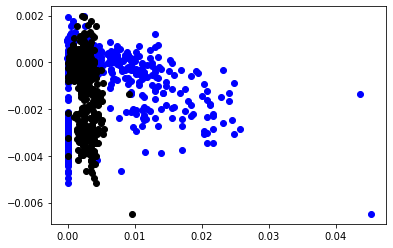

In [107]:
plt.scatter(wdt[0:500], dx[0:500], color = 'blue')
plt.scatter(vdt[0:500], dx[0:500], color = 'black')